# Detecting rooftop available surface for installing PV modules in aerial images using Machine Learning

In [484]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot  as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from model.unet import *
from loss.loss import *
%load_ext autoreload
%autoreload 2
from process_data.data_loader import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [485]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Loading the Data Set
First we load the data set that we will use for training. Each sample is an image with its mask (label). An image is represented as a 3x250x250 array with each of the 3 color chanel being 250x250 pixels. The asssociated mask is a 250x250 array, 

In [486]:
folder_path_image = 'data\image'
folder_path_mask  = 'data\mask'

train_dataset = DataLoaderSegmentation(folder_path_image,folder_path_mask)
train_loader = DataLoader(train_dataset,batch_size=5, shuffle=False,num_workers=2)

# Initiate the model
In this report, we will use the Unet model presented in medical image segmentation, and in the previous papers of the Professor.

In [281]:
model = UNet(3,1,False).to(device)
print(model)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

# Loss & Optimizer

In [5]:
loss_function = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training Loop

In [63]:
num_epochs = 10

for epoch in range(num_epochs):
    print(epoch)
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(torch.squeeze(outputs), torch.squeeze(labels))
        loss.backward()
        optimizer.step()
    print(loss)


0
tensor(0.7984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
1


KeyboardInterrupt: 

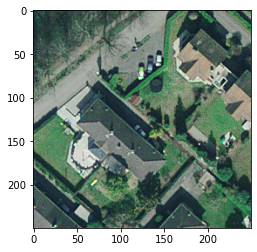

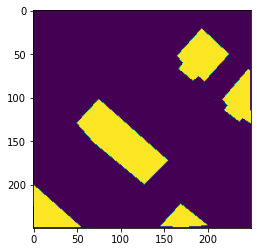

In [523]:
index_random_sample = int(np.random.random()*len(train_loader.dataset))
(x,y) = train_loader.dataset[10]
plt.imshow(np.transpose(x.numpy(),(1,2,0)))
plt.show()
plt.imshow(y)

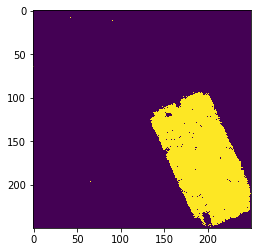

In [351]:
ypred = torch.squeeze(model(torch.unsqueeze(x,0).cuda())).cpu().detach().numpy()
ypred[ypred < 0.08] = 0
ypred[ypred > 0.08] = 1
plt.imshow(ypred)

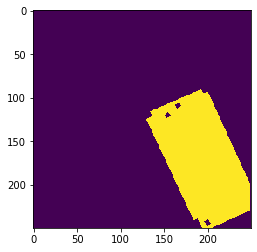

In [352]:
plt.imshow(y)

In [346]:
iou(ypred,y.numpy())

0.8600611951043916

# Export trained model

In [ ]:
torch.save(model.state_dict(), 'model/trained_model.pt')